In [1]:
import pandas as pd
import numpy as np
from scalecast.Forecaster import Forecaster
from scalecast.auxmodels import auto_arima
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(14,7)})

In [2]:
df = pd.read_csv('Corptax_all.csv')
df[['Date Closed','Date Created']] = df[['Date Closed','Date Created']].apply(pd.to_datetime, errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190892 entries, 0 to 190891
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Unnamed: 0         190892 non-null  int64         
 1   index              190892 non-null  int64         
 2   Case Number        190892 non-null  int64         
 3   Subject            190891 non-null  object        
 4   Date Created       190892 non-null  datetime64[ns]
 5   Date Closed        190772 non-null  datetime64[ns]
 6   Origin             190892 non-null  object        
 7   Priority           190892 non-null  object        
 8   Team               190890 non-null  object        
 9   Case Type          187269 non-null  object        
 10  SLA                190843 non-null  object        
 11  Problem Statement  187361 non-null  object        
 12  Product            190765 non-null  object        
 13  Product Area       190672 non-null  object  

In [3]:
fill_dt = pd.Timestamp.now().normalize()
df['Date Closed'] = df['Date Closed'].fillna(fill_dt)

In [4]:
df.isna().sum()

Unnamed: 0                0
index                     0
Case Number               0
Subject                   1
Date Created              0
Date Closed               0
Origin                    0
Priority                  0
Team                      2
Case Type              3623
SLA                      49
Problem Statement      3531
Product                 127
Product Area            220
Product Category     143167
Product Type         185713
Jurisdiction          67731
Resolution             3119
KB #                 138592
KB Title             140655
dtype: int64

In [5]:
df = df.dropna(axis=0, subset=['Product', 'Product Area'])

In [6]:
df.isna().sum()

Unnamed: 0                0
index                     0
Case Number               0
Subject                   1
Date Created              0
Date Closed               0
Origin                    0
Priority                  0
Team                      2
Case Type              3610
SLA                      47
Problem Statement      3522
Product                   0
Product Area              0
Product Category     142947
Product Type         185493
Jurisdiction          67618
Resolution             3109
KB #                 138420
KB Title             140483
dtype: int64

In [7]:
df['Year']= df['Date Created'].dt.year
df['Month']= df['Date Created'].dt.month
df['Week']= df['Date Created'].dt.isocalendar().week
df['week_num'] = df['Week'] + (df['Year'] - df['Year'].min())*52

In [8]:
df['Date'] = df['Date Created'].dt.date 
drop_columns = ['Date Closed','Date Created','Unnamed: 0',]
df.drop(drop_columns, axis=1, inplace=True)
df.head()

,index,Case Number,Subject,Origin,Priority,Team,Case Type,SLA,Problem Statement,Product,...,Product Type,Jurisdiction,Resolution,KB #,KB Title,Year,Month,Week,week_num,Date
0,0,204977,Efile Acceptance,Web,Medium,Tax Preparation,Efile,Platinum,We transmitted a Michigan return still have no...,Compliance,...,NaN,US.MI,Answer exists KB,041324813494120,How to understand the Transmission Monitor,2017,1,1,1,2017-01-02
1,1,204979,Oregon STAT help: Previous Case 203787 Client ...,Web,High,Tax Preparation,Question / How To,Silver,Oregon STAT help: Previous Case 203787 Client ...,Provision,...,NaN,US.OR,Customer no longer needs assistance,NaN,NaN,2017,1,1,1,2017-01-02
2,2,204980,Data map incorrectly pulling in values,Web,Medium,Tax Preparation,Question / How To,Silver,Corptax Office Import - Credit Account imports...,Office - Excel Add-In,...,NaN,US,Answer exists KB,041414821333274,Corptax® Office - How to place an IF formula i...,2017,1,1,1,2017-01-02
3,3,204981,The New Corptax Connect Website is not properl...,Web,High,Tax Preparation,Problem / Error,Silver,Searches can't be performed on the new system....,Websites,...,NaN,NaN,Answer exists KB,161216104028927,Connections Error - Uh Oh something went wron...,2017,1,1,1,2017-01-02
4,4,204986,LD400 is not reflecting a temporary adjustment,E-mail,Medium,Tax Preparation,Problem / Error,Platinum,LD400 is not reflecting a temporary adjustment,Compliance,...,NaN,US,Answer exists KB,041622907012748,Adjustments do not flow to LD400 workpaper and...,2017,1,1,1,2017-01-03


In [9]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')

In [10]:
df.rename(columns={'Case Number':'Case_Number', 'Product Area': 'Product_Area'}, inplace=True)

In [11]:
df['PPA'] = df['Product'] + " : " + df['Product_Area']
df.head()

,index,Case_Number,Subject,Origin,Priority,Team,Case Type,SLA,Problem Statement,Product,...,Jurisdiction,Resolution,KB #,KB Title,Year,Month,Week,week_num,Date,PPA
0,0,204977,Efile Acceptance,Web,Medium,Tax Preparation,Efile,Platinum,We transmitted a Michigan return still have no...,Compliance,...,US.MI,Answer exists KB,041324813494120,How to understand the Transmission Monitor,2017,1,1,1,2017-01-02,Compliance : Returns / Reports
1,1,204979,Oregon STAT help: Previous Case 203787 Client ...,Web,High,Tax Preparation,Question / How To,Silver,Oregon STAT help: Previous Case 203787 Client ...,Provision,...,US.OR,Customer no longer needs assistance,NaN,NaN,2017,1,1,1,2017-01-02,Provision : State
2,2,204980,Data map incorrectly pulling in values,Web,Medium,Tax Preparation,Question / How To,Silver,Corptax Office Import - Credit Account imports...,Office - Excel Add-In,...,US,Answer exists KB,041414821333274,Corptax® Office - How to place an IF formula i...,2017,1,1,1,2017-01-02,Office - Excel Add-In : Import / Export
3,3,204981,The New Corptax Connect Website is not properl...,Web,High,Tax Preparation,Problem / Error,Silver,Searches can't be performed on the new system....,Websites,...,NaN,Answer exists KB,161216104028927,Connections Error - Uh Oh something went wron...,2017,1,1,1,2017-01-02,Websites : Connections (https://connect.corpta...
4,4,204986,LD400 is not reflecting a temporary adjustment,E-mail,Medium,Tax Preparation,Problem / Error,Platinum,LD400 is not reflecting a temporary adjustment,Compliance,...,US,Answer exists KB,041622907012748,Adjustments do not flow to LD400 workpaper and...,2017,1,1,1,2017-01-03,Compliance : Returns / Reports


In [18]:
df.PPA.nunique()

113

In [19]:
filter = ['Compliance', 'International (US)','Office - Excel Add-In','Provision','Partnership / S Corp / Pass-Through']
df1 =  df[df['Product'].isin(filter)]
df1.head()

,index,Case_Number,Subject,Origin,Priority,Team,Case Type,SLA,Problem Statement,Product,...,Jurisdiction,Resolution,KB #,KB Title,Year,Month,Week,week_num,Date,PPA
0,0,204977,Efile Acceptance,Web,Medium,Tax Preparation,Efile,Platinum,We transmitted a Michigan return still have no...,Compliance,...,US.MI,Answer exists KB,041324813494120,How to understand the Transmission Monitor,2017,1,1,1,2017-01-02,Compliance : Returns / Reports
1,1,204979,Oregon STAT help: Previous Case 203787 Client ...,Web,High,Tax Preparation,Question / How To,Silver,Oregon STAT help: Previous Case 203787 Client ...,Provision,...,US.OR,Customer no longer needs assistance,NaN,NaN,2017,1,1,1,2017-01-02,Provision : State
2,2,204980,Data map incorrectly pulling in values,Web,Medium,Tax Preparation,Question / How To,Silver,Corptax Office Import - Credit Account imports...,Office - Excel Add-In,...,US,Answer exists KB,041414821333274,Corptax® Office - How to place an IF formula i...,2017,1,1,1,2017-01-02,Office - Excel Add-In : Import / Export
4,4,204986,LD400 is not reflecting a temporary adjustment,E-mail,Medium,Tax Preparation,Problem / Error,Platinum,LD400 is not reflecting a temporary adjustment,Compliance,...,US,Answer exists KB,041622907012748,Adjustments do not flow to LD400 workpaper and...,2017,1,1,1,2017-01-03,Compliance : Returns / Reports
6,6,204992,Form 2220 Line 19 dates.,Web,Medium,Tax Preparation,Problem / Error,Platinum,Form 2220 Line 19 dates are repeating. This is...,Compliance,...,US,Answer exists KB,041335414275440,IRS e-Services and Business MeF Maintenance in...,2017,1,1,1,2017-01-03,Compliance : Amounts


In [20]:
df1.PPA.value_counts()

Compliance : Returns / Reports                             77888
International (US) : Returns / Reports                     14589
Compliance : Amounts                                        8515
Compliance : Install / Rollover                             7121
Compliance : Configuration / Setup                          5964
Partnership / S Corp / Pass-Through : Returns / Reports     5927
International (US) : Foreign Processing                     5461
Provision : Federal                                         4489
Compliance : Import / Export                                3299
Compliance : Environment Maintenance                        3187
International (US) : Tax Cuts and Jobs Act                  3089
International (US) : Calculation / Posting                  3041
Provision : Configuration / Setup                           2787
Provision : State                                           1901
International (US) : Configuration / Setup                  1673
Compliance : BEPS CbC    

In [21]:
len(df1.PPA.value_counts())

54

In [22]:
list(df1.PPA.value_counts()[df1.PPA.value_counts() > 1600].index)

['Compliance : Returns / Reports',
 'International (US) : Returns / Reports',
 'Compliance : Amounts',
 'Compliance : Install / Rollover',
 'Compliance : Configuration / Setup',
 'Partnership / S Corp / Pass-Through : Returns / Reports',
 'International (US) : Foreign Processing',
 'Provision : Federal',
 'Compliance : Import / Export',
 'Compliance : Environment Maintenance',
 'International (US) : Tax Cuts and Jobs Act',
 'International (US) : Calculation / Posting',
 'Provision : Configuration / Setup',
 'Provision : State',
 'International (US) : Configuration / Setup']

length of dataframe :  68
the series is not stationary
Performing stepwise search to minimize aic
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=639.482, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=625.192, Time=0.23 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=637.733, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=631.825, Time=0.02 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=623.984, Time=0.34 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=625.057, Time=0.93 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=1.72 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=625.291, Time=0.28 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=625.971, Time=0.54 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=625.563, Time=0.48 se

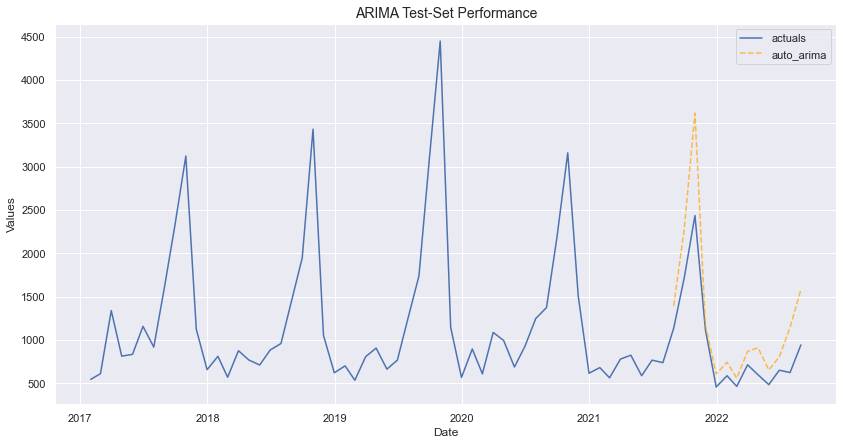

Compliance : Returns / Reports
AUGUST
        DATE  Actuals  FittedVals    Residuals
7 2017-08-31   1617.0   40.875412  1576.124588
         DATE  Actuals  FittedVals  Residuals
19 2018-08-31   1461.0  1634.46572 -173.46572
         DATE  Actuals  FittedVals  Residuals
31 2019-08-31   1739.0  1565.90142  173.09858
         DATE  Actuals   FittedVals   Residuals
43 2020-08-31   1373.0  1776.062973 -403.062973
         DATE  Actuals   FittedVals  Residuals
55 2021-08-31   1135.0  1184.055755 -49.055755
         DATE  Actuals   FittedVals   Residuals
67 2022-08-31    942.0  1272.937053 -330.937053
============================END=================================
============================END=================================
============================END=================================
============================END=================================
============================END=================================
============================END=================================
length o

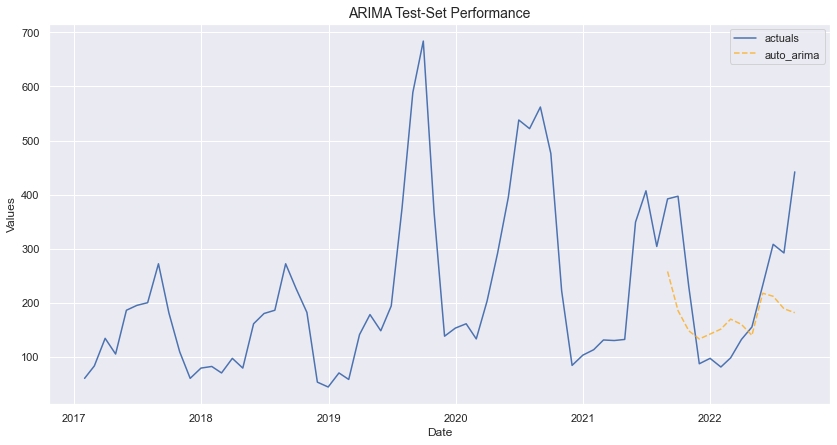

International (US) : Returns / Reports
AUGUST
        DATE  Actuals  FittedVals  Residuals
7 2017-08-31    272.0  208.938546  63.061454
         DATE  Actuals  FittedVals  Residuals
19 2018-08-31    272.0   223.82832   48.17168
         DATE  Actuals  FittedVals   Residuals
31 2019-08-31    589.0  428.963662  160.036338
         DATE  Actuals  FittedVals  Residuals
43 2020-08-31    562.0  494.991832  67.008168
         DATE  Actuals  FittedVals   Residuals
55 2021-08-31    392.0  261.738465  130.261535
         DATE  Actuals  FittedVals  Residuals
67 2022-08-31    442.0   325.65428  116.34572
============================END=================================
============================END=================================
============================END=================================
============================END=================================
============================END=================================
============================END=================================
length of 

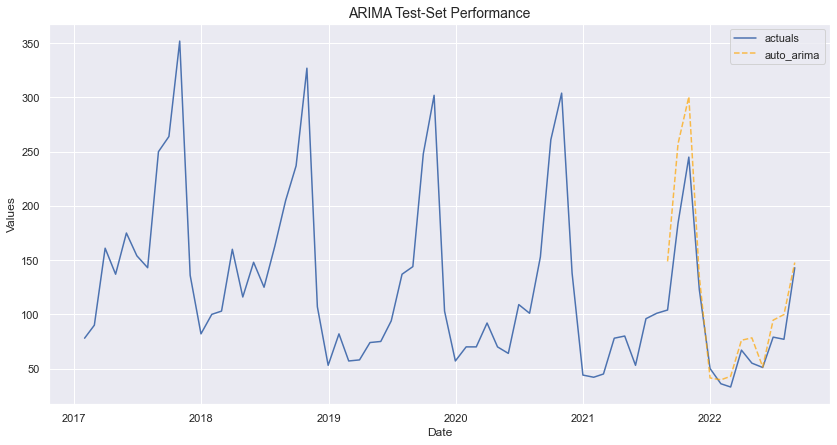

Compliance : Amounts
AUGUST
        DATE  Actuals  FittedVals   Residuals
7 2017-08-31    250.0    0.328247  249.671753
         DATE  Actuals  FittedVals  Residuals
19 2018-08-31    205.0  248.919183 -43.919183
         DATE  Actuals  FittedVals  Residuals
31 2019-08-31    144.0  178.722846 -34.722846
         DATE  Actuals  FittedVals  Residuals
43 2020-08-31    153.0  133.437589  19.562411
         DATE  Actuals  FittedVals  Residuals
55 2021-08-31    104.0  149.412274 -45.412274
         DATE  Actuals  FittedVals  Residuals
67 2022-08-31    143.0   90.580134  52.419866
============================END=================================
============================END=================================
============================END=================================
============================END=================================
============================END=================================
============================END=================================
length of dataframe :  68
the 

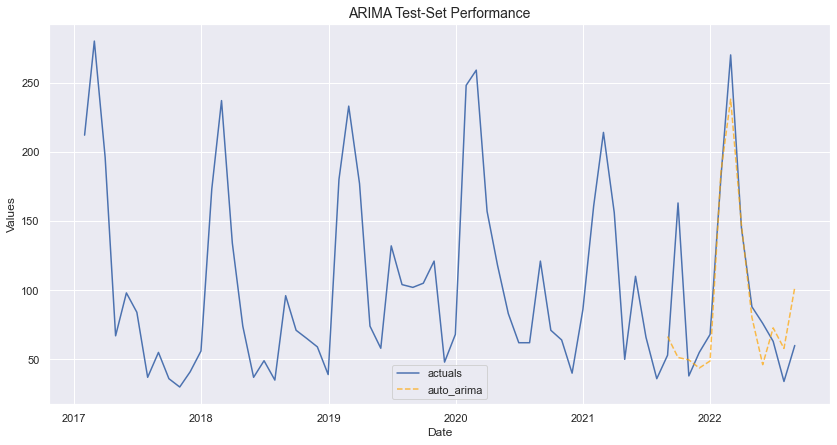

Compliance : Install / Rollover
AUGUST
        DATE  Actuals  FittedVals  Residuals
7 2017-08-31     55.0    0.122725  54.877275
         DATE  Actuals  FittedVals  Residuals
19 2018-08-31     96.0   45.583169  50.416831
         DATE  Actuals  FittedVals  Residuals
31 2019-08-31    102.0    94.15766    7.84234
         DATE  Actuals  FittedVals  Residuals
43 2020-08-31    121.0   89.877809  31.122191
         DATE  Actuals  FittedVals  Residuals
55 2021-08-31     53.0   82.607561 -29.607561
         DATE  Actuals  FittedVals  Residuals
67 2022-08-31     60.0   91.279242 -31.279242
============================END=================================
============================END=================================
============================END=================================
============================END=================================
============================END=================================
============================END=================================
length of dataframe :

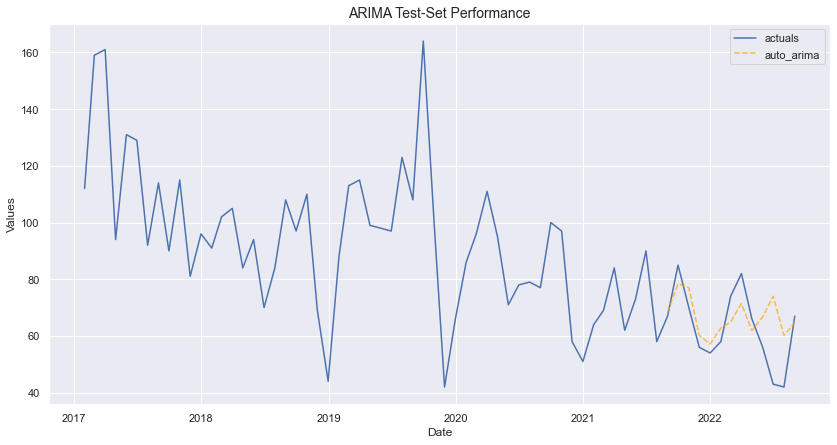

Compliance : Configuration / Setup
AUGUST
        DATE  Actuals  FittedVals  Residuals
7 2017-08-31    114.0  118.190613  -4.190613
         DATE  Actuals  FittedVals  Residuals
19 2018-08-31    108.0    84.87952   23.12048
         DATE  Actuals  FittedVals  Residuals
31 2019-08-31    108.0  114.208411  -6.208411
         DATE  Actuals  FittedVals  Residuals
43 2020-08-31     77.0   84.785409  -7.785409
         DATE  Actuals  FittedVals  Residuals
55 2021-08-31     67.0    68.35806   -1.35806
         DATE  Actuals  FittedVals  Residuals
67 2022-08-31     67.0   52.095458  14.904542
============================END=================================
============================END=================================
============================END=================================
============================END=================================
============================END=================================
============================END=================================
length of datafram

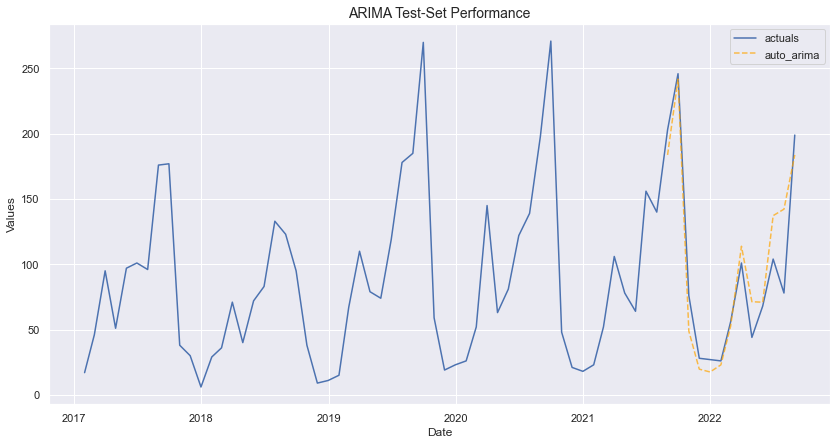

Partnership / S Corp / Pass-Through : Returns / Reports
AUGUST
        DATE  Actuals  FittedVals  Residuals
7 2017-08-31    176.0         0.0      176.0
         DATE  Actuals  FittedVals  Residuals
19 2018-08-31    123.0  175.909347 -52.909347
         DATE  Actuals  FittedVals  Residuals
31 2019-08-31    185.0  144.236064  40.763936
         DATE  Actuals  FittedVals  Residuals
43 2020-08-31    198.0  165.501636  32.498364
         DATE  Actuals  FittedVals  Residuals
55 2021-08-31    203.0  181.861181  21.138819
         DATE  Actuals  FittedVals  Residuals
67 2022-08-31    199.0  192.406207   6.593793
============================END=================================
============================END=================================
============================END=================================
============================END=================================
============================END=================================
============================END===============================

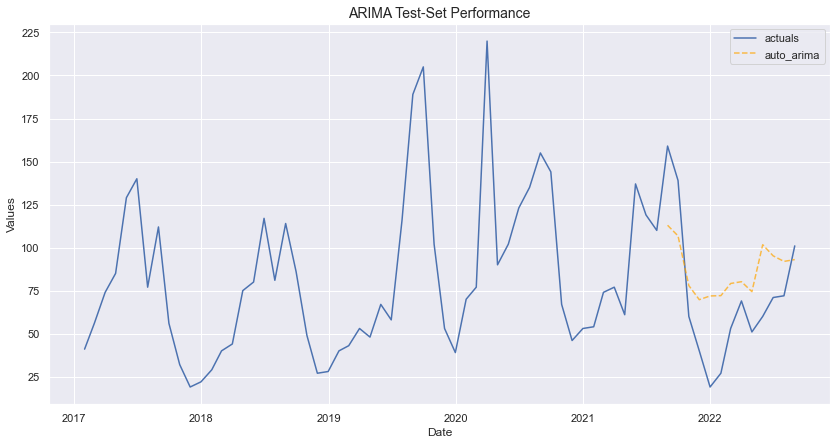

International (US) : Foreign Processing
AUGUST
        DATE  Actuals  FittedVals  Residuals
7 2017-08-31    112.0   76.488372  35.511628
         DATE  Actuals  FittedVals  Residuals
19 2018-08-31    114.0   93.387616  20.612384
         DATE  Actuals  FittedVals  Residuals
31 2019-08-31    189.0  112.806572  76.193428
         DATE  Actuals  FittedVals  Residuals
43 2020-08-31    155.0  145.816399   9.183601
         DATE  Actuals  FittedVals  Residuals
55 2021-08-31    159.0  113.863762  45.136238
         DATE  Actuals  FittedVals  Residuals
67 2022-08-31    101.0   99.926183   1.073817
============================END=================================
============================END=================================
============================END=================================
============================END=================================
============================END=================================
============================END=================================
length of dat

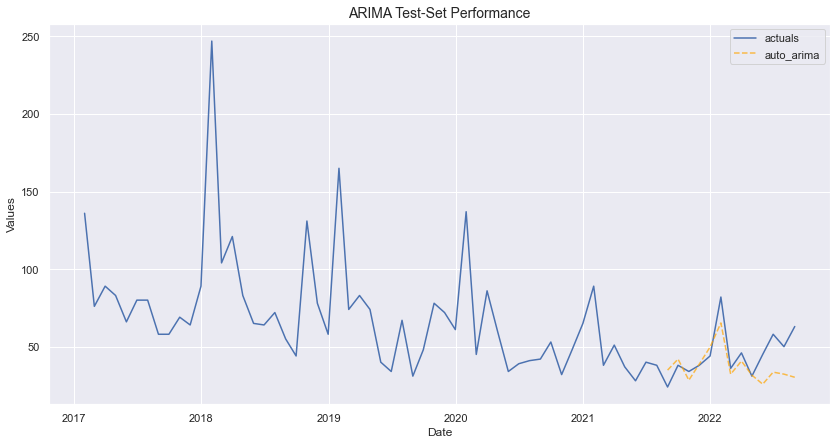

Provision : Federal
AUGUST
        DATE  Actuals  FittedVals  Residuals
7 2017-08-31     58.0   83.247786 -25.247786
         DATE  Actuals  FittedVals  Residuals
19 2018-08-31     55.0   71.166505 -16.166505
         DATE  Actuals  FittedVals  Residuals
31 2019-08-31     31.0   45.558199 -14.558199
         DATE  Actuals  FittedVals  Residuals
43 2020-08-31     42.0   29.955504  12.044496
         DATE  Actuals  FittedVals  Residuals
55 2021-08-31     24.0   34.840939 -10.840939
         DATE  Actuals  FittedVals  Residuals
67 2022-08-31     63.0   35.575056  27.424944
============================END=================================
============================END=================================
============================END=================================
============================END=================================
============================END=================================
============================END=================================
length of dataframe :  68
the ser

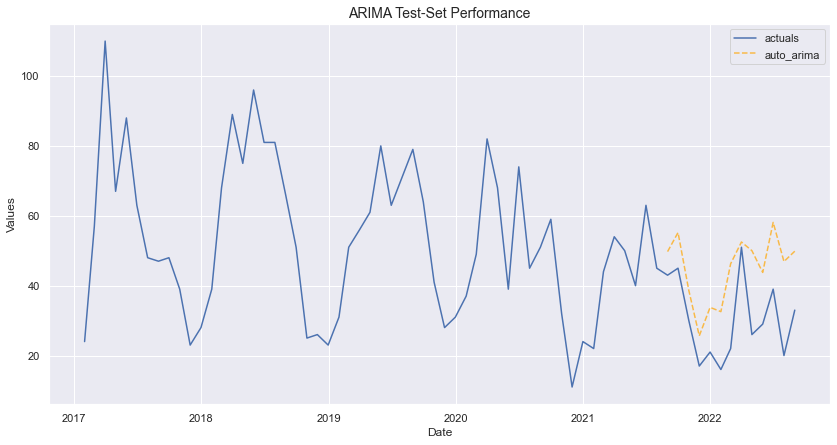

Compliance : Import / Export
AUGUST
        DATE  Actuals  FittedVals  Residuals
7 2017-08-31     47.0   46.190287   0.809713
         DATE  Actuals  FittedVals  Residuals
19 2018-08-31     66.0   63.897074   2.102926
         DATE  Actuals  FittedVals  Residuals
31 2019-08-31     79.0   59.963983  19.036017
         DATE  Actuals  FittedVals  Residuals
43 2020-08-31     51.0   58.098902  -7.098902
         DATE  Actuals  FittedVals  Residuals
55 2021-08-31     43.0   48.823307  -5.823307
         DATE  Actuals  FittedVals  Residuals
67 2022-08-31     33.0   30.802876   2.197124
============================END=================================
============================END=================================
============================END=================================
============================END=================================
============================END=================================
============================END=================================
length of dataframe :  6

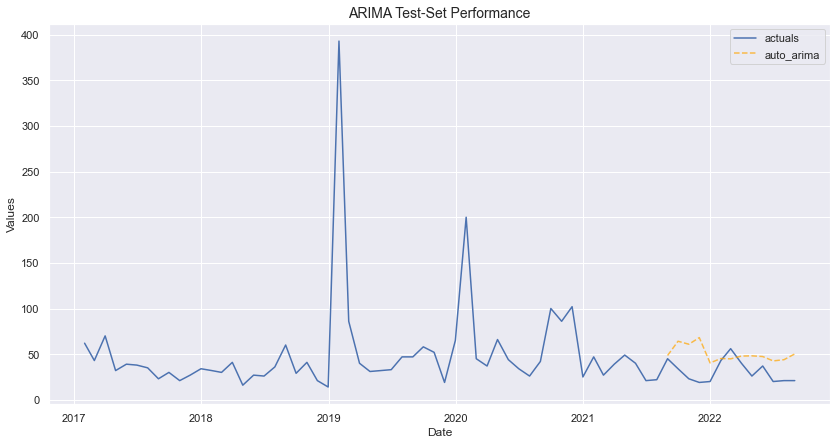

Compliance : Environment Maintenance
AUGUST
        DATE  Actuals  FittedVals  Residuals
7 2017-08-31     23.0   45.912362 -22.912362
         DATE  Actuals  FittedVals  Residuals
19 2018-08-31     60.0   39.815306  20.184694
         DATE  Actuals  FittedVals  Residuals
31 2019-08-31     47.0   51.692902  -4.692902
         DATE  Actuals  FittedVals  Residuals
43 2020-08-31     42.0   44.560547  -2.560547
         DATE  Actuals  FittedVals  Residuals
55 2021-08-31     45.0   45.174427  -0.174427
         DATE  Actuals  FittedVals  Residuals
67 2022-08-31     21.0   45.862091 -24.862091
============================END=================================
============================END=================================
============================END=================================
============================END=================================
============================END=================================
============================END=================================
length of datafr

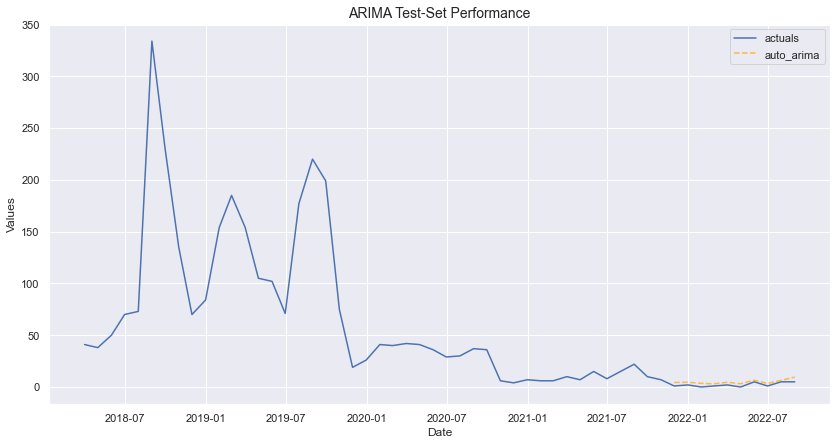

International (US) : Tax Cuts and Jobs Act
AUGUST
Empty DataFrame
Columns: [DATE, Actuals, FittedVals, Residuals]
Index: []
        DATE  Actuals  FittedVals   Residuals
5 2018-08-31    334.0   66.760498  267.239502
         DATE  Actuals  FittedVals  Residuals
17 2019-08-31    220.0  284.179566 -64.179566
         DATE  Actuals  FittedVals  Residuals
29 2020-08-31     37.0   73.711778 -36.711778
         DATE  Actuals  FittedVals  Residuals
41 2021-08-31     22.0   16.941427   5.058573
         DATE  Actuals  FittedVals  Residuals
53 2022-08-31      5.0     8.25264   -3.25264
============================END=================================
============================END=================================
============================END=================================
============================END=================================
============================END=================================
============================END=================================
length of dataframe :  68


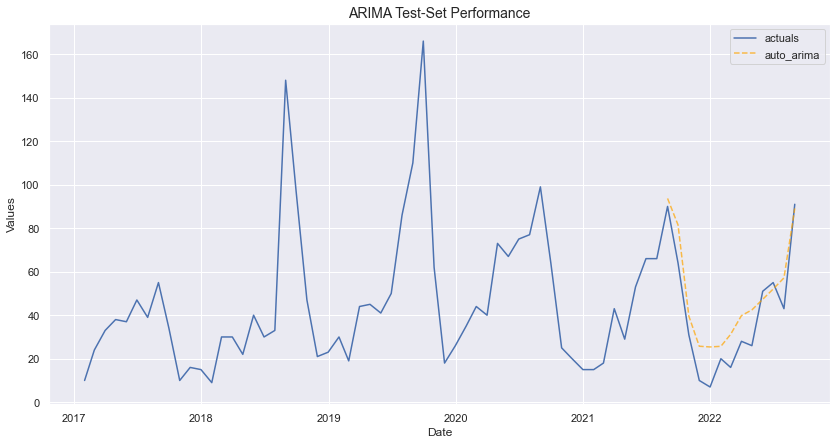

International (US) : Calculation / Posting
AUGUST
        DATE  Actuals  FittedVals  Residuals
7 2017-08-31     55.0   40.952845  14.047155
         DATE  Actuals  FittedVals   Residuals
19 2018-08-31    148.0   44.681087  103.318913
         DATE  Actuals  FittedVals  Residuals
31 2019-08-31    110.0  104.942717   5.057283
         DATE  Actuals  FittedVals  Residuals
43 2020-08-31     99.0  101.576024  -2.576024
         DATE  Actuals  FittedVals  Residuals
55 2021-08-31     90.0   95.471179  -5.471179
         DATE  Actuals  FittedVals  Residuals
67 2022-08-31     91.0   82.874384   8.125616
============================END=================================
============================END=================================
============================END=================================
============================END=================================
============================END=================================
============================END=================================
length o

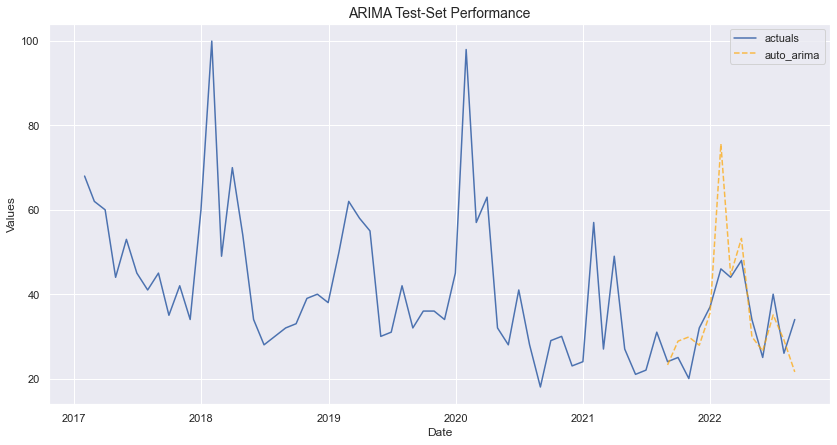

Provision : Configuration / Setup
AUGUST
        DATE  Actuals  FittedVals  Residuals
7 2017-08-31     45.0   46.821273  -1.821273
         DATE  Actuals  FittedVals  Residuals
19 2018-08-31     32.0   40.085132  -8.085132
         DATE  Actuals  FittedVals  Residuals
31 2019-08-31     32.0   39.329569  -7.329569
         DATE  Actuals  FittedVals  Residuals
43 2020-08-31     18.0   32.818428 -14.818428
         DATE  Actuals  FittedVals  Residuals
55 2021-08-31     24.0   23.989196   0.010804
         DATE  Actuals  FittedVals  Residuals
67 2022-08-31     34.0   23.458333  10.541667
============================END=================================
============================END=================================
============================END=================================
============================END=================================
============================END=================================
============================END=================================
length of dataframe

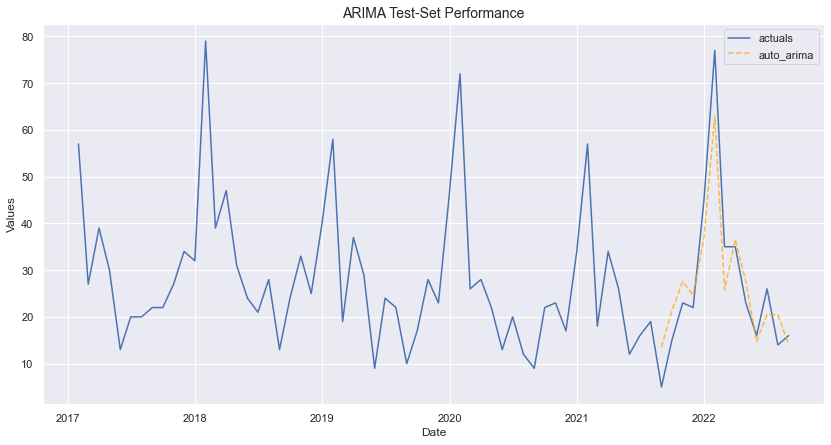

Provision : State
AUGUST
        DATE  Actuals  FittedVals  Residuals
7 2017-08-31     22.0   25.197888  -3.197888
         DATE  Actuals  FittedVals  Residuals
19 2018-08-31     13.0    25.43055  -12.43055
         DATE  Actuals  FittedVals  Residuals
31 2019-08-31     10.0   17.559556  -7.559556
         DATE  Actuals  FittedVals  Residuals
43 2020-08-31      9.0   11.485256  -2.485256
         DATE  Actuals  FittedVals  Residuals
55 2021-08-31      5.0   13.478955  -8.478955
         DATE  Actuals  FittedVals  Residuals
67 2022-08-31     16.0    9.964723   6.035277
============================END=================================
============================END=================================
============================END=================================
============================END=================================
============================END=================================
============================END=================================
length of dataframe :  68
the serie

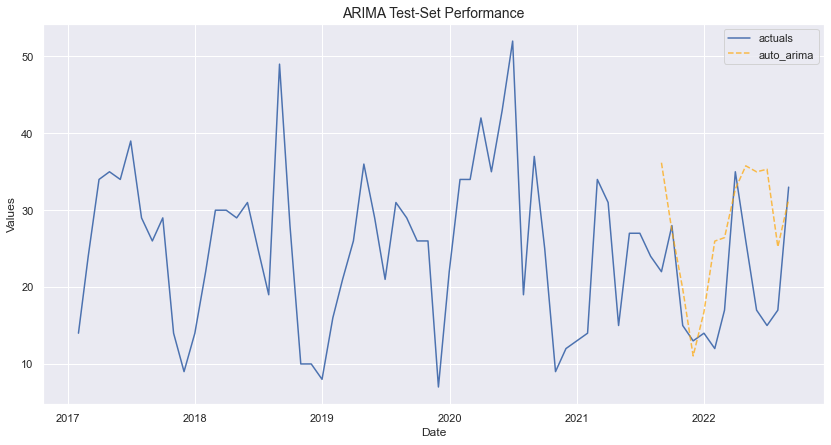

International (US) : Configuration / Setup
AUGUST
        DATE  Actuals  FittedVals  Residuals
7 2017-08-31     26.0   23.149581   2.850419
         DATE  Actuals  FittedVals  Residuals
19 2018-08-31     49.0   23.010439  25.989561
         DATE  Actuals  FittedVals  Residuals
31 2019-08-31     29.0   31.708454  -2.708454
         DATE  Actuals  FittedVals  Residuals
43 2020-08-31     37.0   26.789699  10.210301
         DATE  Actuals  FittedVals  Residuals
55 2021-08-31     22.0   34.659614 -12.659614
         DATE  Actuals  FittedVals  Residuals
67 2022-08-31     33.0   29.585783   3.414217
============================END=================================
============================END=================================
============================END=================================
============================END=================================
============================END=================================
============================END=================================


In [27]:
res = {}
for i in list(df1.PPA.value_counts()[df1.PPA.value_counts() > 1600].index):
    train_rmse = []
    test_rmse = []
    months = []
    
    #grouping by month
    temp = df1[df1.PPA == i][["Case_Number","Date"]]
    newdf = pd.DataFrame(temp.groupby([temp["Date"].dt.date]).count()["Case_Number"])
    newdf = newdf.reset_index()
    newdf.index = newdf.Date
    newdf['Date'] = pd.to_datetime(newdf['Date'], errors='coerce')
    newdf = newdf.asfreq('D')
    newdf = newdf.groupby(pd.Grouper(freq="M")).sum()
    
    print("length of dataframe : ",newdf.shape[0])
    f = Forecaster(y=newdf['Case_Number'],current_dates=newdf.index)
    f.generate_future_dates(12)
    f.set_test_length(.2)
    critical_pval = 0.05
    stat, pval, _, _, _, _ = f.adf_test(full_res=True)
    print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
    auto_arima(
        f,
        start_P=1,
        start_q=1,
        max_p=10,
        max_q=10,
        m=12,
        seasonal=True,
        max_P=10, 
        max_D=10,
        max_Q=10,
        max_d=10,
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True,
        information_criterion="aic",
        alpha=0.05,
        scoring='mse',
        call_me='auto_arima',)
    f.plot_test_set(ci=False,models='auto_arima')
    plt.title('ARIMA Test-Set Performance',size=14)
    plt.show()
    results = f.export(to_excel=True,excel_name='mlr.xlsx')
    result_train = f.export_fitted_vals(model = "auto_arima")
    print(i)
    print("AUGUST")
    print(result_train[result_train["DATE"] == "2017-08-31"])
    print(result_train[result_train["DATE"] == "2018-08-31"])
    print(result_train[result_train["DATE"] == "2019-08-31"])
    print(result_train[result_train["DATE"] == "2020-08-31"])
    print(result_train[result_train["DATE"] == "2021-08-31"])
    print(result_train[result_train["DATE"] == "2022-08-31"])
    train_rmse.append(round(results["model_summaries"]["InSampleRMSE"][0],2))
    test_rmse.append(round(results["model_summaries"]["TestSetRMSE"][0],2))

    for j in range(0,4):
        months.append(round(results["lvl_fcsts"].iloc[j]["auto_arima"]))
    model = "arima-S"
    res[i] = [model, train_rmse[0], test_rmse[0], newdf.min()[0], newdf.max()[0], newdf.mean()[0], newdf.std()[0],months[0],months[1],months[2],months[3]]
    print("============================END=================================")
    print("============================END=================================")
    print("============================END=================================")
    print("============================END=================================")
    print("============================END=================================")
    print("============================END=================================")


In [338]:
ind = ["model","train_rmse","test_rmse","min", "max", "mean", "std", "sept", "oct", "nov", "dec"]
res_df = pd.DataFrame(res)
res_df.index = ind
round(res_df,2).T.to_csv("all_mods.csv")

In [291]:
res_df

,Compliance : Returns / Reports,International (US) : Returns / Reports,Compliance : Amounts,Compliance : Install / Rollover,Compliance : Configuration / Setup,International (US) : Foreign Processing,Provision : Federal,Compliance : Import / Export,Compliance : Environment Maintenance,International (US) : Tax Cuts and Jobs Act,International (US) : Calculation / Posting,Provision : Configuration / Setup,Provision : State,International (US) : Configuration / Setup
model,mlr,mlr,mlr,mlr,mlr,arima-S,mlr,mlr,arima-S,mlr,arima-S,arima-S,mlr,arima-S
train_rmse,293.46,56.09,20.93,28.99,13.82,32.71,13.98,9.0,47.74,12.39,21.69,11.99,6.95,8.14
test_rmse,254.61,69.47,28.7,54.25,10.73,32.03,12.44,10.06,24.59,13.23,12.03,9.78,10.28,10.48
min,456.0,44.0,33.0,30.0,42.0,19.0,24.0,11.0,14.0,0.0,7.0,18.0,5.0,7.0
max,4449.0,684.0,352.0,280.0,164.0,220.0,247.0,110.0,393.0,334.0,166.0,100.0,79.0,52.0
mean,1145.411765,214.544118,125.220588,104.720588,87.705882,80.308824,66.014706,48.514706,46.867647,57.203704,44.720588,40.985294,27.955882,24.602941
std,799.908021,149.335387,76.434704,67.240012,26.948851,44.954789,36.106597,22.153126,50.457875,72.929374,31.394859,16.28798,15.411213,10.16159
sept,1496,489,208,78,74,97,51,32,38,18,78,32,30,27
oct,2107,241,234,75,44,67,50,9,36,18,37,31,33,20
nov,1006,99,134,42,30,61,44,7,33,16,21,30,27,14
